In [1]:
from google.colab import files
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [2]:
#data=pd.read_csv('C:/Users/huiho/.vscode/vscode/vgames2_filled.csv')

In [3]:
uploaded = files.upload()

Saving vgames2_filled.csv to vgames2_filled.csv


In [4]:
data = pd.read_csv('./vgames2_filled.csv')

In [5]:
df = data.copy()

In [6]:
# Year Genre Publisher 결측치 있었으나 엑셀을 통해 결측치 채웠음 > 채우는 과정에서 찾지 못한 5 행이 드랍되었음
# Year float > int
# Sales object > float
# Sales는 기본적으로 M(백만)을 단위로 취하고 있다고 판단되어
# K는 나누기 1000을 해주고 M은 M을 제거 후 1000000 곱함
# Platform 2600 > Atari로 변경
# Publisher에서 Unknown 값 발견됨 > Publisher의 중요도?

In [7]:
# Sales 컬럼 명 리스트로 받아옴
sales_col = df.columns[5:]

In [8]:
k_arr=[]

for i in sales_col:
  df[i] = df[i].str.replace('M', '') # Sales 각 열에서 M 제거
  k_arr.append(df[df[i].str.contains('K')].index) # 우선 Sales 각 열에서 K를 포함하고 있는 행의 인덱스 리스트 4개를 arr에 저장
  df[i] = df[i].str.replace('K','') # Sales 각 열에서 K 제거
  df[i] = df[i].astype(float) # Sales type float으로 변경

In [9]:
for i in np.arange(len(sales_col)): # k_arr에 저장한 K를 포함하고 있던 행의 인덱스 리스트 4개 세트를 가져오기 위해 0,1,2,3
  for j in k_arr[i]: # 각 리스트에서 값을 가져옴
    df.loc[j, sales_col[i]] = df.loc[j, sales_col[i]] / 1000 # K를 포함하고 있던 행의 sales 값에 1000 나눠줌

In [10]:
df.iloc[:,5:] = df.iloc[:,5:]*1000000 # 모든 M(백만) 단위를 실제 값으로

In [11]:
df.iloc[:,5:] = df.iloc[:,5:].astype(int, errors='ignore') # Sales 정수형 변환

In [12]:
# Platform 값으로 2600이 마음에 안 들어서 Atari로 바꿨음
for i in df[df['Platform']=='2600'].index:
  df.loc[i, 'Platform'] = 'Atari'

In [13]:
# Sales 모든 값이 0인 데이터가 하나 존재 했었고 이를 드랍했음
df = df.drop(df[(df[sales_col[0]]==0)&(df[sales_col[1]]==0)&(df[sales_col[2]]==0)&(df[sales_col[3]]==0)].index)

In [14]:
# 이름과 플랫폼이 함께 중복되는 행이 5쌍 발견 되었음
# Need for Speed: Most Wanted는 동일한 이름으로 상이한 연도에 출시되어 이름명에 연도까지 표기해주고자 함
# Sonic the Hedgehog은 미국 출시와 유럽 출시인 행으로 확인되어 하나의 행으로 값을 합해주고자 함(연도는 1년 차이가 있긴 함)
# Madden NFL 13이랑 Wii de Asobu: Metroid Prime은 중복 제거해주고자 함

In [15]:
# Need for Speed: Most Wanted 연도에 맞게 이름에 연도도 추가

In [16]:
df['Name'] = df['Name'].str.strip(' ')

In [17]:
for i in df[df['Name']=='Need for Speed: Most Wanted'].index:
  df.loc[i, 'Name'] = df.loc[i, 'Name']+ ' ' + '({})'.format(df.loc[i, 'Year'])

In [18]:
# Sonic the Hedgehog 2007년 출시는 나머지는 Sales가 0이고, jp만 0.48임 > 이 값을 2006년 출시에 합하고자 함
df.loc[15700,'EU_Sales'] = df.loc[15700,'EU_Sales']+0.48
df = df.drop(8647, axis=0)

In [19]:
# 이름과 플랫폼이 함께 중복되는 데이터 제거
df = df.drop(df[df[['Name','Platform']].duplicated()].index)

In [20]:
# 2017년 데이터는 적어서 드랍
df = df[df['Year']<2017]

In [21]:
df = df.reset_index(drop=True)

In [22]:
# 지역에 따라 선호하는 게임 장르

In [23]:
genre_name = df['Genre'].unique().tolist()
genre_sort = df.sort_values(by='Genre', ascending=True)['Genre'].unique().tolist()

In [24]:
# 지역별 판매된 게임 수 그래프 그리기

In [25]:
df_all_counts = pd.DataFrame(None, columns=['NA_Sales', 'EU_Sales','JP_Sales','Other_Sales'])
for i in sales_col:
  df_all_counts[i] = df[~(df[i]==0)].groupby('Genre')[i].count()
df_all_counts = df_all_counts.reset_index().sort_values(by='Genre', ascending=True)

In [26]:
df_all_counts_melt = df_all_counts.melt(id_vars=['Genre'], value_vars=['NA_Sales','EU_Sales','JP_Sales','Other_Sales'], var_name='Region', value_name='Sales')

In [27]:
# barplot 장르별 출시가 된 총 게임 수
df_count = df.groupby('Genre').count().reset_index()
df_count = df_count.iloc[:,:2]
df_count.columns = ['Genre','Count']

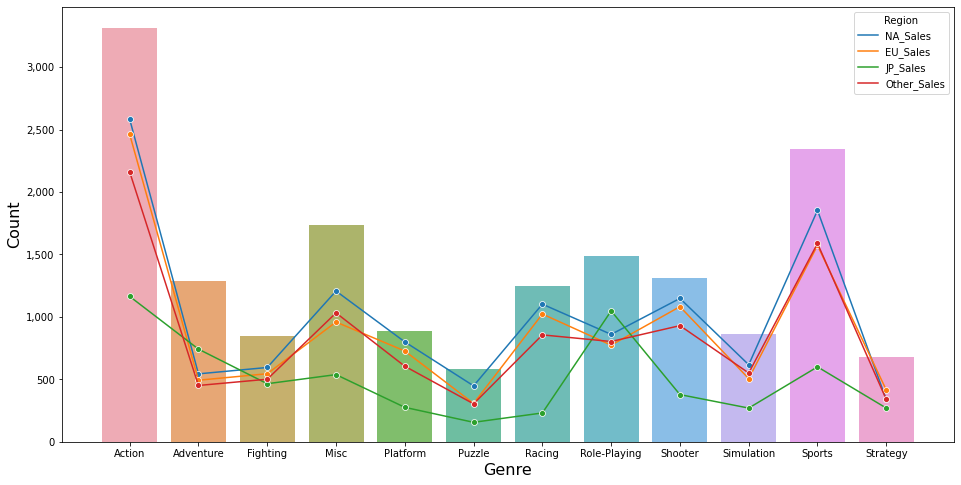

In [28]:
# line - 장르별 판매된 게임 수 (지역별)
# bar - 장르별 출시된 게임 수
plt.figure(figsize=(16,8))
sns.barplot(x='Genre', y='Count', data=df_count, ci=None, alpha=0.8)
sns.lineplot(x='Genre', y='Sales', hue='Region', data=df_all_counts_melt, marker='o')
plt.xlabel('Genre', fontsize=16)
plt.ylabel('Count', fontsize=16)
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
plt.show()

In [29]:
# 장르별 게임 총 판매량 (지역별)

In [30]:
df_all_sum = pd.DataFrame(None, columns=['NA_Sales', 'EU_Sales','JP_Sales','Other_Sales'])
for i in sales_col:
  df_all_sum[i] = df[~(df[i]==0)].groupby('Genre')[i].sum()
df_all_sum = df_all_sum.reset_index().sort_values(by='Genre', ascending=True)

In [31]:
# lineplot 지역을 hue로 지정하고자 Region으로 melt 만들어줌
df_all_sum_melt = df_all_sum.melt(id_vars=['Genre'], value_vars=['NA_Sales','EU_Sales','JP_Sales','Other_Sales'], var_name='Region', value_name='Sales')
# Sales 정수형 변환
df_all_sum_melt['Sales'] = df_all_sum_melt['Sales'].astype(int)

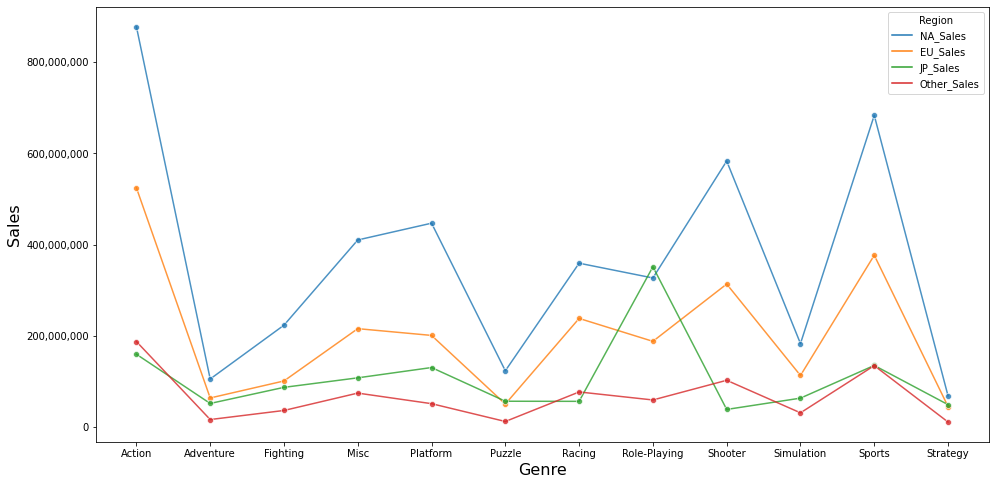

In [32]:
# 장르별 게임 총 판매량 (지역별)
plt.figure(figsize=(16,8))
sns.lineplot(x='Genre', y='Sales', hue='Region', data=df_all_sum_melt, ci=None, alpha=0.8, marker='o')
plt.xlabel('Genre', fontsize=16)
plt.ylabel('Sales', fontsize=16)
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
plt.show()

In [33]:
# 지역별 게임 판매량을 합한 값을 Sum_Sales 열로 추가
sum_sales=[]
for i in range(df.shape[0]):
  sum_sales.append(df.iloc[i,5:].sum())
df['Sum_Sales'] = sum_sales

df.iloc[:,5:] = df.iloc[:,5:].astype(int, errors='ignore')

In [34]:
# 연도별 게임 트렌드 분석 (장르)

In [35]:
# 연도별 가장 많은 판매 게임 수를 가진 장르
year_genre_count = pd.DataFrame(df.groupby(['Year','Genre'])['Sum_Sales'].count()).reset_index()
# 컬럼명 변경
year_genre_count.columns = ['Year','Genre','Count']
# 연도와 카운트 오름차순으로 정렬
year_genre_count =year_genre_count.sort_values(by=['Year','Count'], ascending=True)
# 각 연도 마지막 행은 오름차순이므로 가장 카운트가 큰 값임
year_genre_count.drop_duplicates(subset='Year', keep='last', inplace=True)
year_genre_count = year_genre_count.reset_index(drop=True)

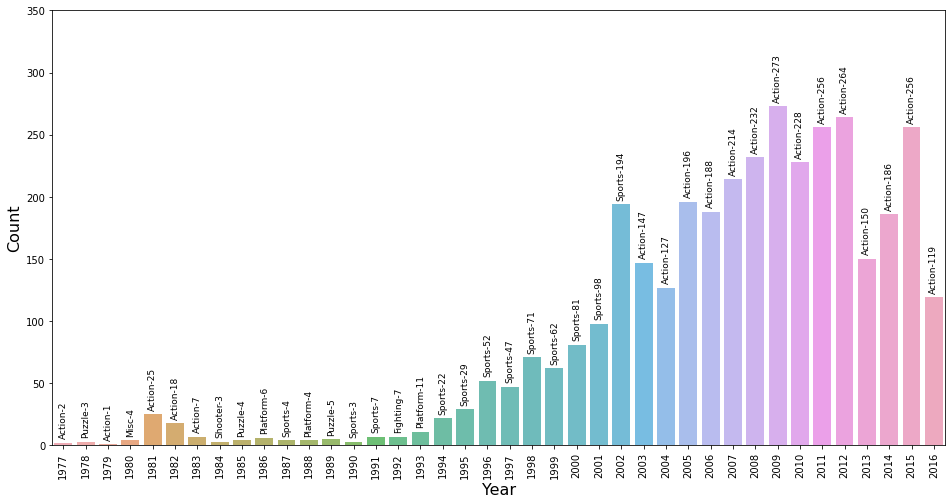

In [36]:
# 연도별 가장 많은 판매 게임 수를 가진 장르
plt.figure(figsize=(16,8))
sns.barplot(x='Year', y='Count', data=year_genre_count, ci=None, alpha=0.8)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.yticks(np.arange(0, 351, 50))
plt.xticks(rotation=90)
cnt=0
for i in year_genre_count['Count']:
    plt.text(x=cnt, y=i + 5, s=str(year_genre_count['Genre'].tolist()[cnt] + '-' + str(i)),
            color='black', size=9, rotation=90, ha='center')
    cnt+=1
plt.show()

In [37]:
# 연도별 가장 높은 판매량을 가진 장르
year_genre_sum = pd.DataFrame(df.groupby(['Year','Genre'])['Sum_Sales'].sum()).reset_index()
# 연도와 총 판매량 오름차순 정렬
year_genre_sum = year_genre_sum.sort_values(by=['Year', 'Sum_Sales'], ascending=True)
# 오름차순이므로 각 연도의 마지막 행은 총 판매량이 가장 큰 값임
year_genre_sum.drop_duplicates(subset='Year', keep='last', inplace=True)
# 소수점 반올림
year_genre_sum['Sum_Sales'] = np.round(year_genre_sum['Sum_Sales'], -1)

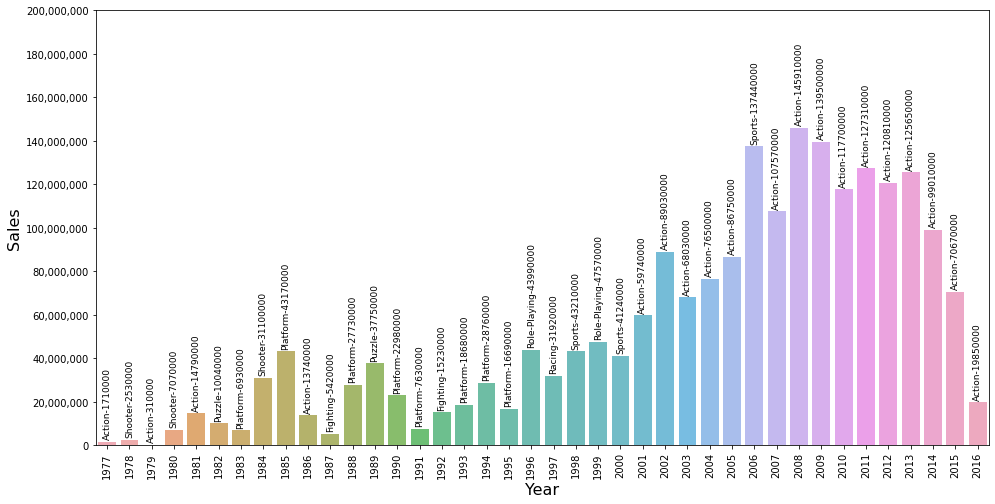

In [38]:
# 연도별 가장 높은 판매량을 가진 장르
plt.figure(figsize=(16,8))
sns.barplot(x='Year', y='Sum_Sales', data=year_genre_sum, ci=None, alpha=0.8)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Sales', fontsize=16)
plt.yticks(np.arange(0, 200000001, 20000000))
plt.xticks(rotation=90)
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
cnt=0
for i in year_genre_sum['Sum_Sales']:
    plt.text(x=cnt, y=i + 2000000, s=str(year_genre_sum['Genre'].tolist()[cnt] + '-' + str(i)),
            color='black', size=9, rotation=90, ha='center')
    cnt+=1
plt.show()

In [39]:
# x축에 장르, y축에 연도를 둔 게임 수 히트맵 그리기
year_genre_count_pivot = pd.DataFrame(df.groupby(['Year','Genre'])['Sum_Sales'].count()).reset_index()
# pivot을 통해 데이터 프레임을 히트맵 모양으로 만들기
year_genre_count_pivot = year_genre_count_pivot.pivot(index='Year', columns='Genre', values='Sum_Sales')

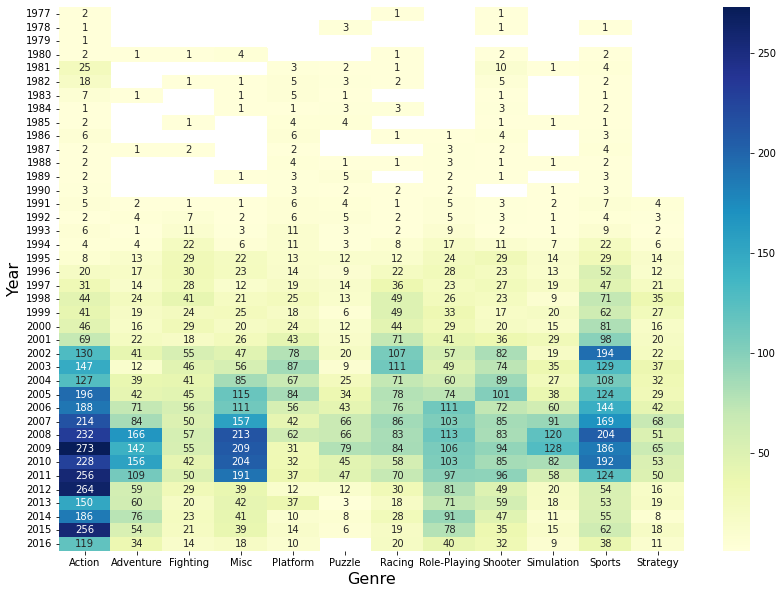

In [40]:
# x축에 장르, y축에 연도를 둔 게임 수 히트맵 그리기
plt.figure(figsize=(14,10))
sns.heatmap(year_genre_count_pivot, annot=True, fmt='.0f', cmap="YlGnBu")
plt.xlabel('Genre', fontsize=16)
plt.ylabel('Year', fontsize=16)
plt.show()

In [41]:
# x축에 장르, y축에 연도를 둔 게임 판매량 히트맵 그리기
year_genre_sum_pivot = pd.DataFrame(df.groupby(['Year','Genre'])['Sum_Sales'].sum()).reset_index()
# pivot을 통해 데이터 프레임을 히트맵 모양으로 만들기
year_genre_sum_pivot = year_genre_sum_pivot.pivot(index='Year', columns='Genre', values='Sum_Sales')
# 숫자가 길어져서 백만으로 나눠줌 (단위 백만)
year_genre_sum_pivot = year_genre_sum_pivot / 1000000

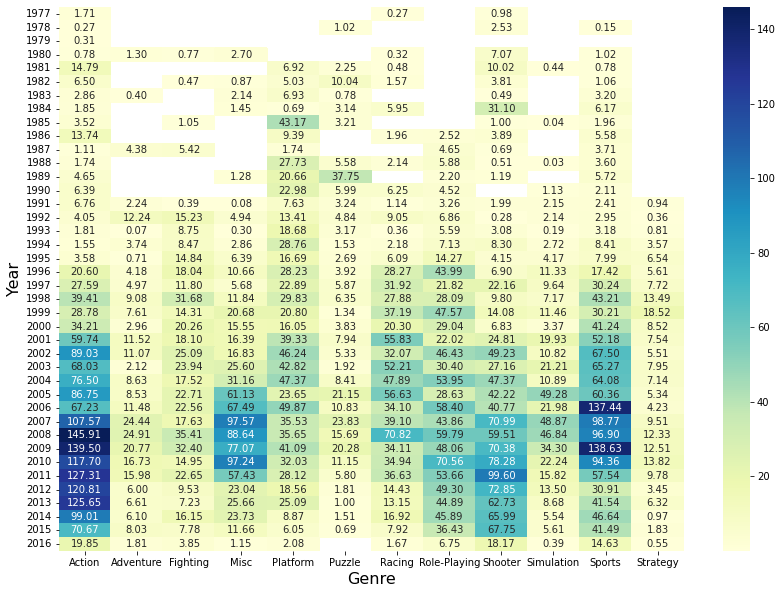

In [42]:
# x축에 장르, y축에 연도를 둔 게임 판매량 히트맵 그리기
plt.figure(figsize=(14,10))
sns.heatmap(year_genre_sum_pivot, annot=True, fmt='.2f', cmap="YlGnBu")
plt.xlabel('Genre', fontsize=16)
plt.ylabel('Year', fontsize=16)
plt.show()

In [43]:
# 연도별 가장 많은 판매 게임 수를 가진 플랫폼
year_plf_count = pd.DataFrame(df.groupby(['Year','Platform'])['Sum_Sales'].count()).reset_index()
# 컬럼명 변경
year_plf_count.columns = ['Year','Platform','Count']
# 연도와 카운트 오름차순으로 정렬
year_plf_count =year_plf_count.sort_values(by=['Year','Count'], ascending=True)
# 각 연도 마지막 행은 오름차순이므로 가장 카운트가 큰 값임
year_plf_count.drop_duplicates(subset='Year', keep='last', inplace=True)
year_plf_count = year_plf_count.reset_index(drop=True)

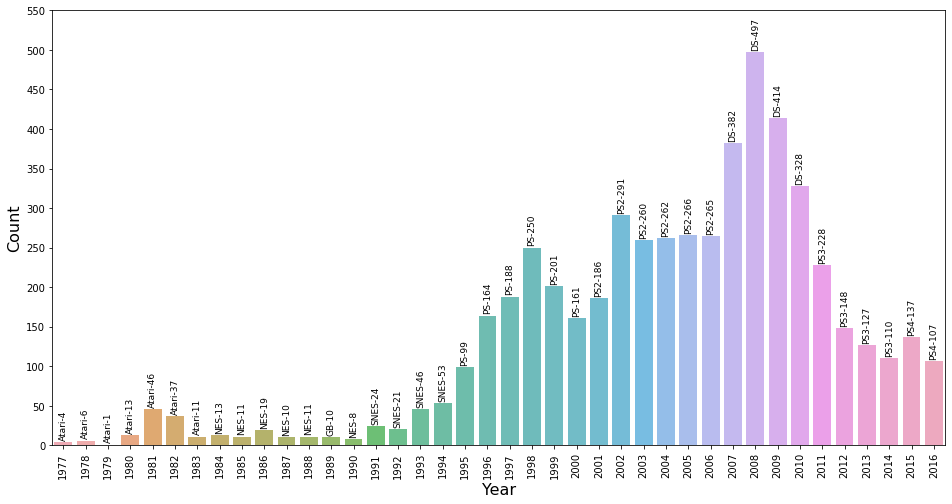

In [44]:
# 연도별 가장 많은 판매 게임 수를 가진 플랫폼
plt.figure(figsize=(16,8))
sns.barplot(x='Year', y='Count', data=year_plf_count, ci=None, alpha=0.8)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.yticks(np.arange(0, 551, 50))
plt.xticks(rotation=90)
cnt=0
for i in year_plf_count['Count']:
    plt.text(x=cnt, y=i + 5, s=str(year_plf_count['Platform'].tolist()[cnt] + '-' + str(i)),
            color='black', size=9, rotation=90, ha='center')
    cnt+=1
plt.show()

In [45]:
# 연도별 가장 높은 총 판매량을 가진 플랫폼
year_plf_sum = pd.DataFrame(df.groupby(['Year','Platform'])['Sum_Sales'].sum()).reset_index()
# 컬럼명 변경
year_plf_sum.columns = ['Year','Platform','Sum_Sales']
# 연도와 판매량 오름차순으로 정렬
year_plf_sum =year_plf_sum.sort_values(by=['Year','Sum_Sales'], ascending=True)
# 각 연도 마지막 행은 오름차순이므로 가장 판매량이 큰 값임
year_plf_sum.drop_duplicates(subset='Year', keep='last', inplace=True)
year_plf_sum = year_plf_sum.reset_index(drop=True)

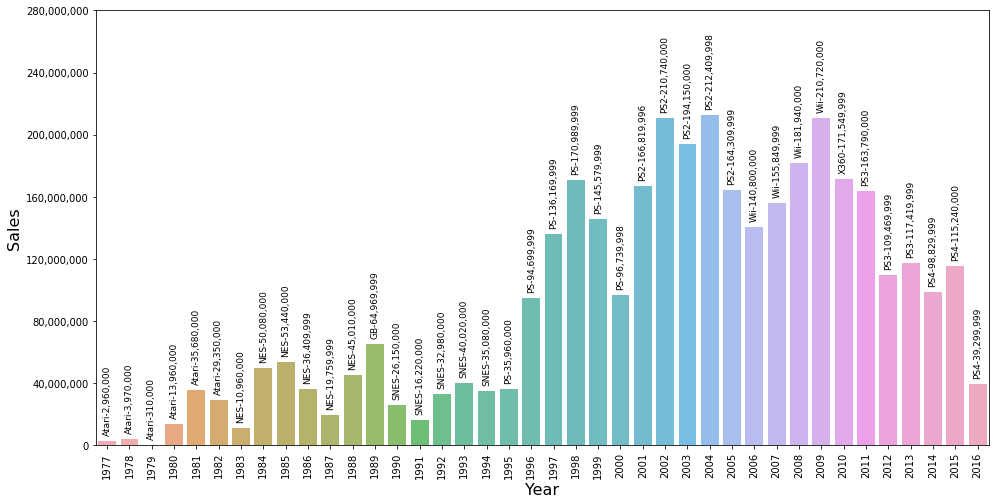

In [46]:
plt.figure(figsize=(16,8))
sns.barplot(x='Year', y='Sum_Sales', data=year_plf_sum, ci=None, alpha=0.8)
plt.yticks(np.arange(0, 280000001, 40000000))
plt.xlabel('Year', fontsize=16)
plt.ylabel('Sales', fontsize=16)
plt.xticks(rotation=90)
cnt=0
for i in year_plf_sum['Sum_Sales']:
    plt.text(x=cnt, y=i + 5000000, s=str(year_plf_sum['Platform'].tolist()[cnt] + '-' + '{:,}'.format(i)),
            color='black', size=9, rotation=90, ha='center')
    cnt+=1
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
plt.show()

In [47]:
 #2000년대 플랫폼 중 4개 종류로 분류 (Nintendo, PlayStation, XBOX, PC) (DC,WS 제외)

In [48]:
dfy = df[df['Year']>1999]
dfy = dfy.reset_index(drop=True)

In [49]:
# 플랫폼 유니크 값을 4개 종류로 분류
ntd_2000 = ['DS','Wii','GBA','GC','3DS','GB','N64','WiiU']
ps_2000 = ['PSP','PS3','PS','PS4','PS2','PSV']
pc_2000 = ['PC']
xb_2000 = ['XB','X360','XOne']

plf4_list = ['Nintendo','PlayStation','PC','XBOX']

plf4_2000 = np.array([ntd_2000,ps_2000,pc_2000,xb_2000])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if __name__ == '__main__':


In [50]:
for i in range(len(plf4_list)):
  for j in dfy[dfy[dfy.isin(plf4_2000[i])]['Platform'].notna()]['Platform'].index:
    dfy.loc[j, 'Platform_4'] = plf4_list[i]

In [51]:
# 플랫폼4 종류에 포함하지 않는 행 드랍
dfy.dropna(subset=['Platform_4'], inplace=True)

In [52]:
# 연도와 플랫폼 별로 묶고 게임 수 카운트
year_plf4_count_line = pd.DataFrame(dfy.groupby(['Year','Platform_4'])['Sum_Sales'].count()).reset_index()

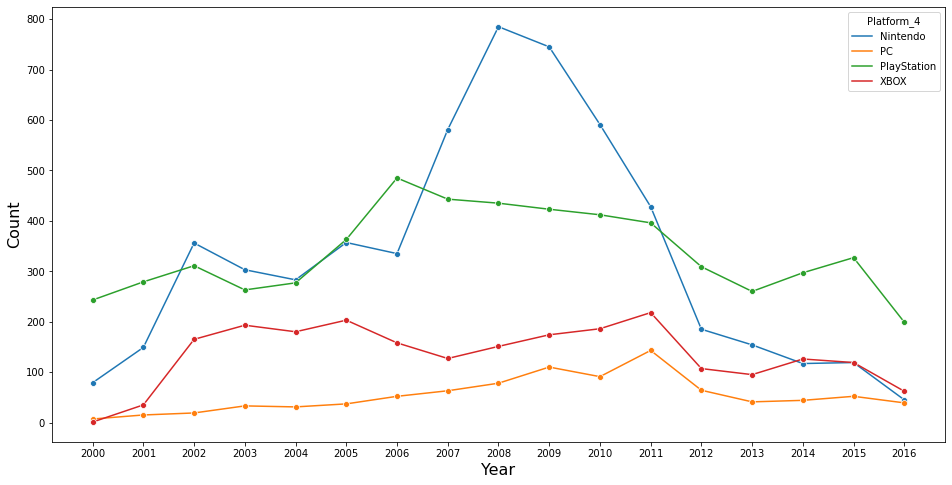

In [53]:
plt.figure(figsize=(16,8))
sns.lineplot(x='Year', y='Sum_Sales', hue='Platform_4', data=year_plf4_count_line, marker='o')
plt.xlabel('Year', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xticks(np.arange(2000,2017,1))
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
plt.show()

In [54]:
# 연도와 플랫폼 별로 묶고 게임 총 판매량
year_plf4_sum_line = pd.DataFrame(dfy.groupby(['Year','Platform_4'])['Sum_Sales'].sum()).reset_index()

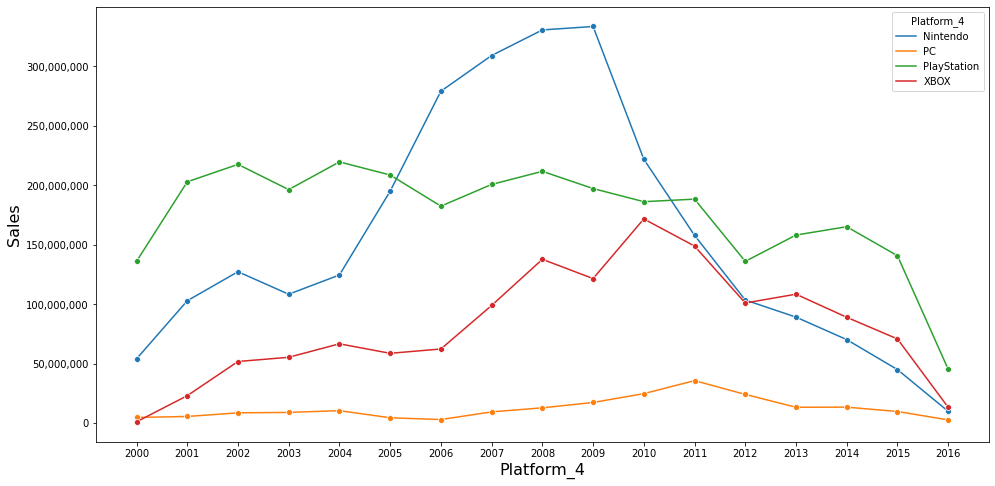

In [55]:
plt.figure(figsize=(16,8))
sns.lineplot(x='Year', y='Sum_Sales', hue='Platform_4', data=year_plf4_sum_line, marker='o')
plt.xlabel('Platform_4', fontsize=16)
plt.ylabel('Sales', fontsize=16)
plt.xticks(np.arange(2000,2017,1))
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
plt.show()

In [56]:
# TOP 10 게임 분석

In [57]:
# 같은 이름을 가진 게임들의 지역별, 총 판매량을 합쳐줌 (플랫폼이 다른 것을 무시) (이름 오름차순 정렬)
df_name = df.groupby('Name')[['NA_Sales','EU_Sales','JP_Sales','Other_Sales','Sum_Sales']].sum()
df_name = df_name.reset_index()

a = df.drop_duplicates(subset='Name').sort_values(by='Name', ascending=True).reset_index(drop=True)
# 연도, 장르 추출
a_add = a.iloc[:,[2,3]]
# 두 프레임 합치기
df_name = pd.concat([df_name, a_add],axis=1)
# 열 정렬
df_name = df_name[['Name', 'Year', 'Genre', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Sum_Sales']]

In [58]:
# 총 판매량 상위 10개 게임
sum_top10 = df_name.nlargest(10, 'Sum_Sales')
# annotate 용
sum_top10_name = sum_top10['Name'].tolist()
sum_top10_year = sum_top10['Year'].tolist()
sum_top10_genre = sum_top10['Genre'].tolist()
sum_top10_sales = sum_top10['Sum_Sales'].tolist()

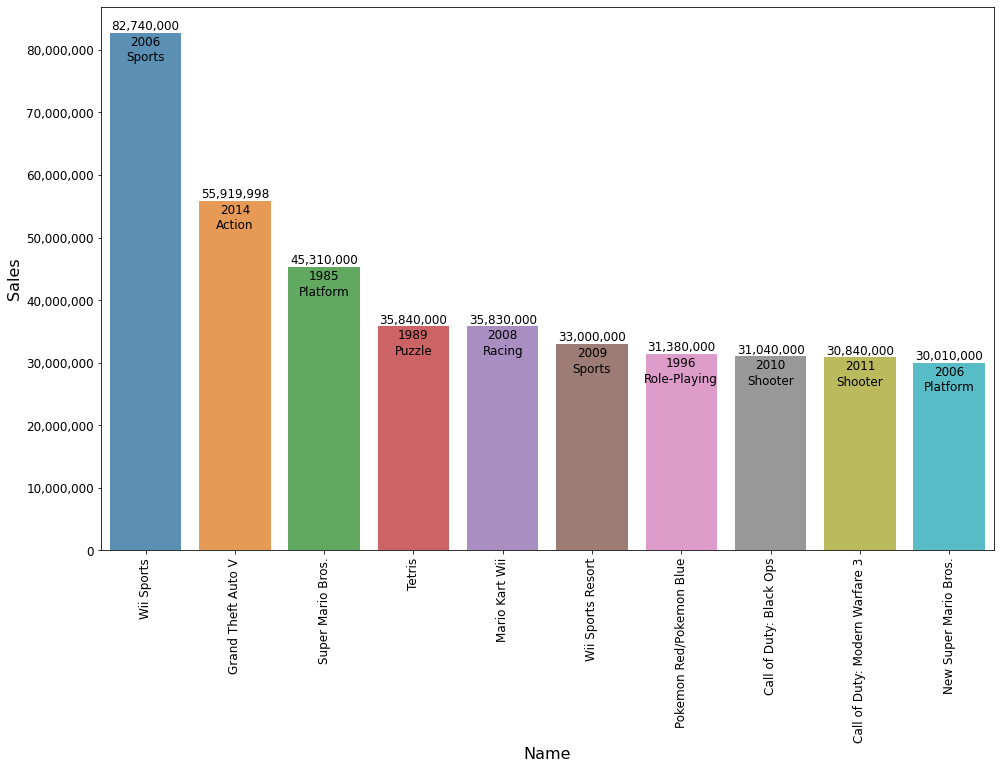

In [59]:
# 총 판매량 상위 10개 게임
plt.figure(figsize=(16,10))
sns.barplot(x='Name', y='Sum_Sales', data=sum_top10, ci=None, alpha=0.8)
plt.xlabel('Name', fontsize=16)
plt.ylabel('Sales', fontsize=16)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
for i in range(len(sum_top10_name)):
    plt.annotate('{:,}'.format(sum_top10_sales[i]), xy=(i, sum_top10_sales[i]), va='bottom', ha='center', fontsize=12)
for i in range(len(sum_top10_name)):
    plt.annotate(sum_top10_year[i], xy=(i, sum_top10_sales[i]-2500000), va='bottom', ha='center', fontsize=12)
for i in range(len(sum_top10_name)):
    plt.annotate(sum_top10_genre[i], xy=(i, sum_top10_sales[i]-5000000), va='bottom', ha='center', fontsize=12)
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
plt.show()

In [60]:
# 2000년~ 같은 이름을 가진 게임들의 지역별, 총 판매량을 합쳐줌 (플랫폼이 다른 것을 무시) (이름 오름차순 정렬)
dfy_name = dfy.groupby('Name')[['NA_Sales','EU_Sales','JP_Sales','Other_Sales','Sum_Sales']].sum()
dfy_name = dfy_name.reset_index()

a = dfy.drop_duplicates(subset='Name').sort_values(by='Name', ascending=True).reset_index(drop=True)
# 연도, 장르 추출
a_add = a.iloc[:,[2,3]]
# 두 프레임 합치기
dfy_name = pd.concat([dfy_name, a_add],axis=1)
# 열 정렬
dfy_name = dfy_name[['Name', 'Year', 'Genre', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Sum_Sales']]

In [61]:
# 2000년~ 총 판매량 상위 10개 게임
ysum_top10 = dfy_name.nlargest(10, 'Sum_Sales')
# annotate용
ysum_top10_name = ysum_top10['Name'].tolist()
ysum_top10_year = ysum_top10['Year'].tolist()
ysum_top10_genre = ysum_top10['Genre'].tolist()
ysum_top10_sales = ysum_top10['Sum_Sales'].tolist()

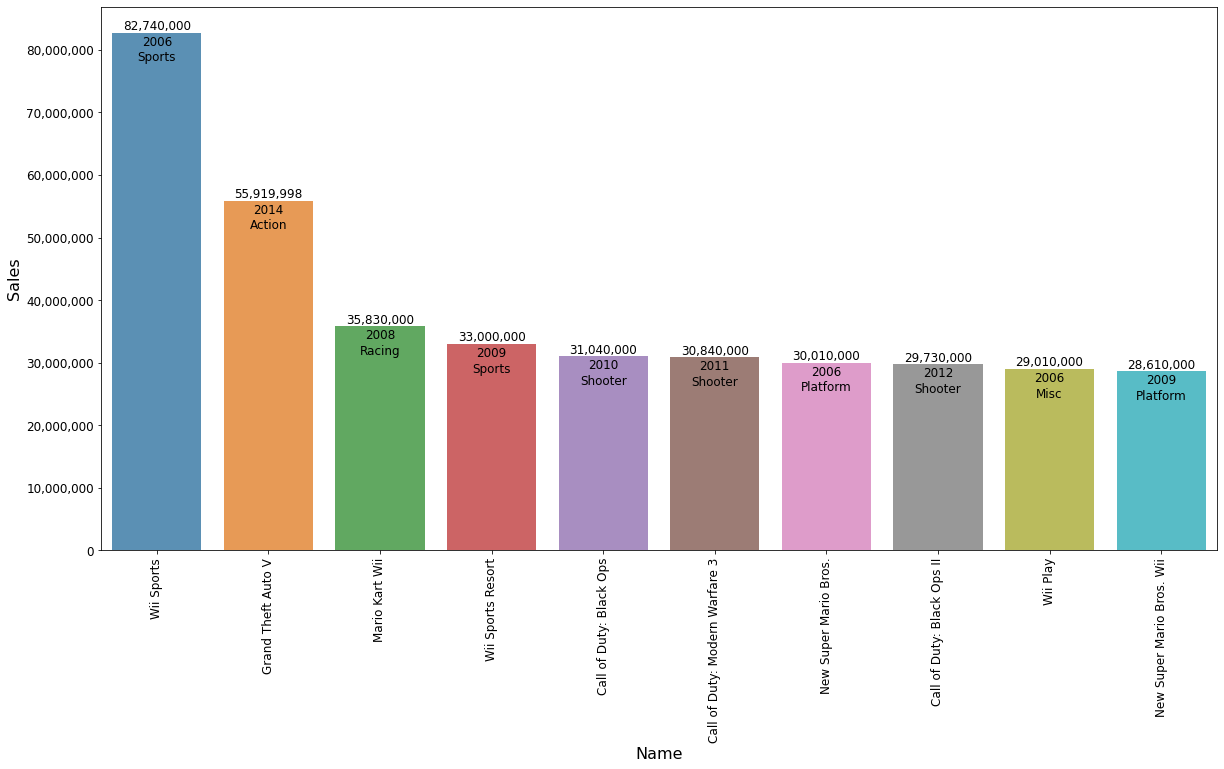

In [62]:
plt.figure(figsize=(20,10))
sns.barplot(x='Name', y='Sum_Sales', data=ysum_top10, ci=None, alpha=0.8)
plt.xlabel('Name', fontsize=16)
plt.ylabel('Sales', fontsize=16)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
for i in range(len(ysum_top10_name)):
    plt.annotate('{:,}'.format(ysum_top10_sales[i]), xy=(i, ysum_top10_sales[i]), va='bottom', ha='center', fontsize=12)
for i in range(len(ysum_top10_name)):
    plt.annotate(ysum_top10_year[i], xy=(i, ysum_top10_sales[i]-2500000), va='bottom', ha='center', fontsize=12)
for i in range(len(ysum_top10_name)):
    plt.annotate(ysum_top10_genre[i], xy=(i, ysum_top10_sales[i]-5000000), va='bottom', ha='center', fontsize=12)
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
plt.show()

In [63]:
# 판매량 상위 10% 목표!!!

In [64]:
# 2000년~2016년 데이터를 기준 상위 10% 추출
dfy_10p = dfy.nlargest(int(np.round((dfy.shape[0]*0.1),0)),columns='Sum_Sales',keep='all').reset_index(drop=True)
# Name	Platform_4	Platform	Year	Genre	Publisher	Sum_Sales 만 추출
dfy_10p = dfy_10p.iloc[:,[0,-1,1,2,3,4,-2]]

In [65]:
# 장르별로 상위 10퍼 게임 수 파악
dfy_10p_genre_count = dfy_10p.groupby('Genre').count().reset_index().iloc[:,:2]
dfy_10p_genre_count.columns = ['Genre','Count']

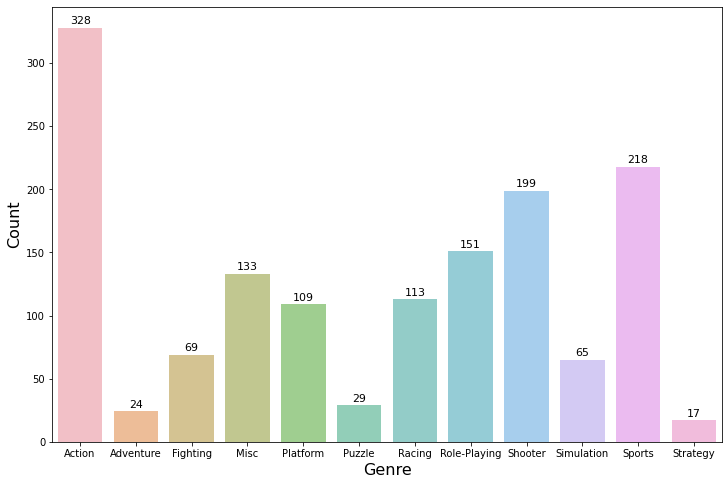

In [66]:
# 상위 10퍼 장르별 게임 수
plt.figure(figsize=(12,8))
sns.barplot(x=dfy_10p_genre_count['Genre'], y=dfy_10p_genre_count['Count'], ci=None, alpha=0.6)
plt.xlabel('Genre', fontsize=16)
plt.ylabel('Count', fontsize=16)
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
cnt=0
for i in dfy_10p_genre_count['Count']:
    plt.text(x=cnt, y=i+3, s=str('{:,}'.format(i)),
            color='black', size=11, ha='center')
    cnt+=1
plt.show()

In [67]:
# 장르별로 상위 10퍼 게임 판매량 파악
dfy_10p_genre_sum = dfy_10p.groupby('Genre').sum().reset_index().iloc[:,[0,2]]
dfy_10p_genre_sum.columns = ['Genre','Sum']

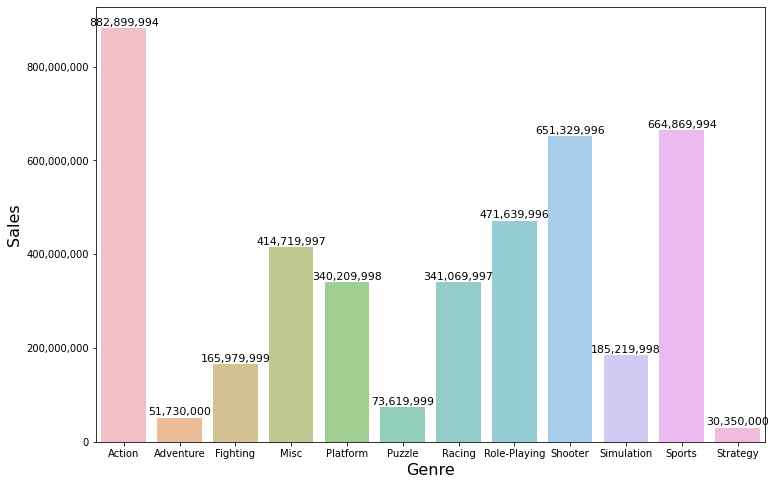

In [68]:
# 상위 10퍼 장르별 게임 판매량
plt.figure(figsize=(12,8))
sns.barplot(x=dfy_10p_genre_sum['Genre'], y=dfy_10p_genre_sum['Sum'], ci=None, alpha=0.6)
plt.xlabel('Genre', fontsize=16)
plt.ylabel('Sales', fontsize=16)
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
cnt=0
for i in dfy_10p_genre_sum['Sum']:
    plt.text(x=cnt, y=i+5000000, s=str('{:,}'.format(i)),
            color='black', size=11, ha='center')
    cnt+=1
plt.show()

In [69]:
# 액션의 시장이 가장 활성화 되어있다고 판단 >> 액션 선택

In [70]:
# 상위 10퍼 게임 중 액션 게임들로 분석

In [71]:
# 액션 필터링
dfy_10p_action_count = dfy_10p[dfy_10p['Genre']=='Action']
# 액션 내 플랫폼4로 게임 수 카운트
dfy_10p_action_count = dfy_10p_action_count.groupby('Platform_4').count()
dfy_10p_action_count = dfy_10p_action_count.reset_index(drop=False).iloc[:,:2]
dfy_10p_action_count.columns = ['Platform_4', 'Count']

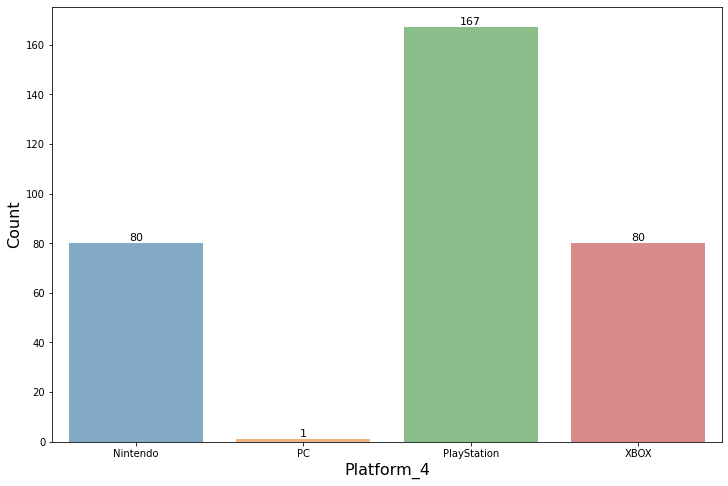

In [72]:
# 상위 10퍼 액션 게임 중 플랫폼4 게임 수
plt.figure(figsize=(12,8))
sns.barplot(x=dfy_10p_action_count['Platform_4'], y=dfy_10p_action_count['Count'], ci=None, alpha=0.6)
plt.xlabel('Platform_4', fontsize=16)
plt.ylabel('Count', fontsize=16)
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
cnt=0
for i in dfy_10p_action_count['Count']:
    plt.text(x=cnt, y=i+1, s=str('{:,}'.format(i)),
            color='black', size=11, ha='center')
    cnt+=1
plt.show()

In [73]:
# 액션 필터링
dfy_10p_action_sum = dfy_10p[dfy_10p['Genre']=='Action']
# 액션 내 플랫폼4로 게임 판매량
dfy_10p_action_sum = dfy_10p_action_sum.groupby('Platform_4').sum()
dfy_10p_action_sum = dfy_10p_action_sum.reset_index(drop=False).iloc[:,[0,2]]
dfy_10p_action_sum.columns = ['Platform_4', 'Sum']

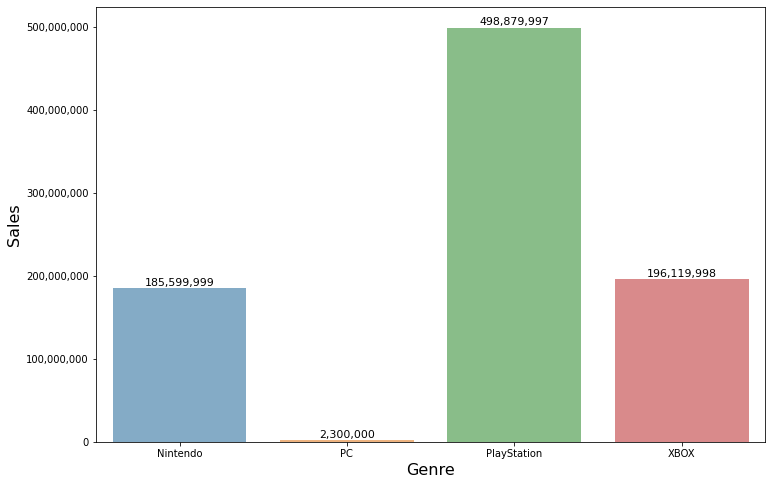

In [74]:
# 상위 10퍼 액션 게임 중 플랫폼4 게임 판매량
plt.figure(figsize=(12,8))
sns.barplot(x=dfy_10p_action_sum['Platform_4'], y=dfy_10p_action_sum['Sum'], ci=None, alpha=0.6)
plt.xlabel('Genre', fontsize=16)
plt.ylabel('Sales', fontsize=16)
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
cnt=0
for i in dfy_10p_action_sum['Sum']:
    plt.text(x=cnt, y=i+3000000, s=str('{:,}'.format(i)),
            color='black', size=11, ha='center')
    cnt+=1
plt.show()

In [75]:
# 플레이스테이션의 시장이 가장 활성화 되어 있다고 판단 >> 플레이스테이션 선택

In [76]:
# 상위 10퍼 게임에서 액션이면서 플스인 행 필터링해서
dfy_10p_action_plat = dfy_10p[(dfy_10p['Genre']=='Action')&(dfy_10p['Platform_4']=='PlayStation')]
# 회사별로 카운트
dfy_10p_action_plat = dfy_10p_action_plat.groupby('Publisher').count()
dfy_10p_action_plat = dfy_10p_action_plat.reset_index(drop=False).iloc[:,:2]
dfy_10p_action_plat.columns = ['Publisher', 'Count']

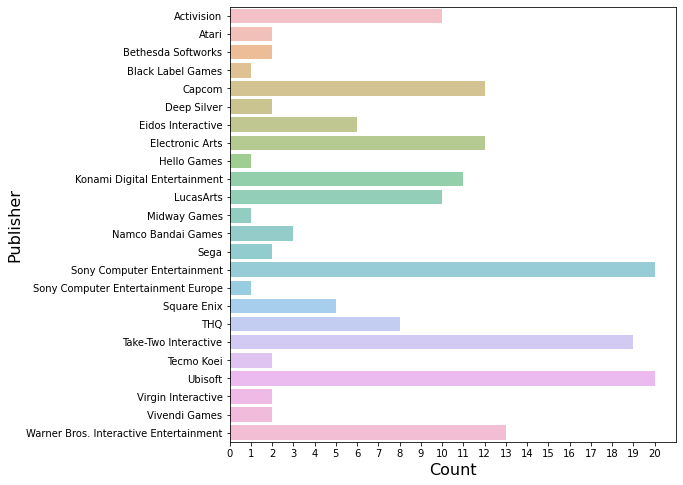

In [77]:
# 상위 10퍼 액션 게임 중 플스를 플랫폼으로 하는 게임 수 회사별 카운트
plt.figure(figsize=(8,8))
sns.barplot(y=dfy_10p_action_plat['Publisher'], x=dfy_10p_action_plat['Count'], ci=None, alpha=0.6)
plt.xticks(np.arange(0,21,1))
plt.xlabel('Count', fontsize=16)
plt.ylabel('Publisher', fontsize=16)
plt.show()

In [78]:
# 소니, 유비, 테이크투가 게임 수에서 눈에 띄는 지표를 갖고 있음

In [79]:
# 상위 10퍼 게임에서 액션이면서 플스인 행 필터링해서
dfy_10p_action_plat_sum = dfy_10p[(dfy_10p['Genre']=='Action')&(dfy_10p['Platform_4']=='PlayStation')]
# 회사별로 판매량 더하기
dfy_10p_action_plat_sum = dfy_10p_action_plat_sum.groupby('Publisher').sum()
dfy_10p_action_plat_sum = dfy_10p_action_plat_sum.reset_index(drop=False).iloc[:,[0,2]]
dfy_10p_action_plat_sum.columns = ['Publisher', 'Sum']

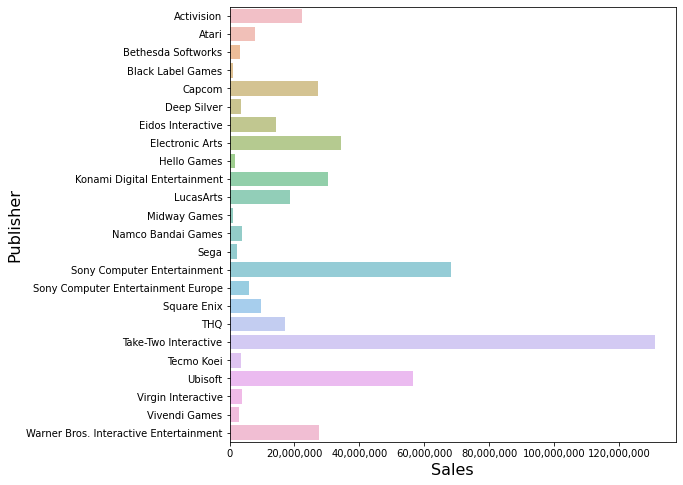

In [80]:
# 상위 10퍼 액션 게임 중 플스를 플랫폼으로 하는 게임 회사별 판매량
plt.figure(figsize=(8,8))
sns.barplot(y=dfy_10p_action_plat_sum['Publisher'], x=dfy_10p_action_plat_sum['Sum'], ci=None, alpha=0.6)
plt.xlabel('Sales', fontsize=16)
plt.ylabel('Publisher', fontsize=16)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])
plt.show()

In [81]:
# 판매량 면에서 테이크투가 다른 곳들에 비해 압도적인 판매량을 보임

In [82]:
# 테이크투 게임 분석 (테이크투 회사의 TOP5 판매량 게임을 통해)

In [83]:
# 테이크투 필터링
taketwo_top5 = dfy[dfy['Publisher']=='Take-Two Interactive']
# 테이크투 내에서 같은 이름들을 합침 (플랫폼 무시)
taketwo_top5 = taketwo_top5.groupby('Name').sum().reset_index().sort_values(by='Sum_Sales',ascending=False).head(5)
taketwo_top5 = taketwo_top5.iloc[:,[0,-1]]

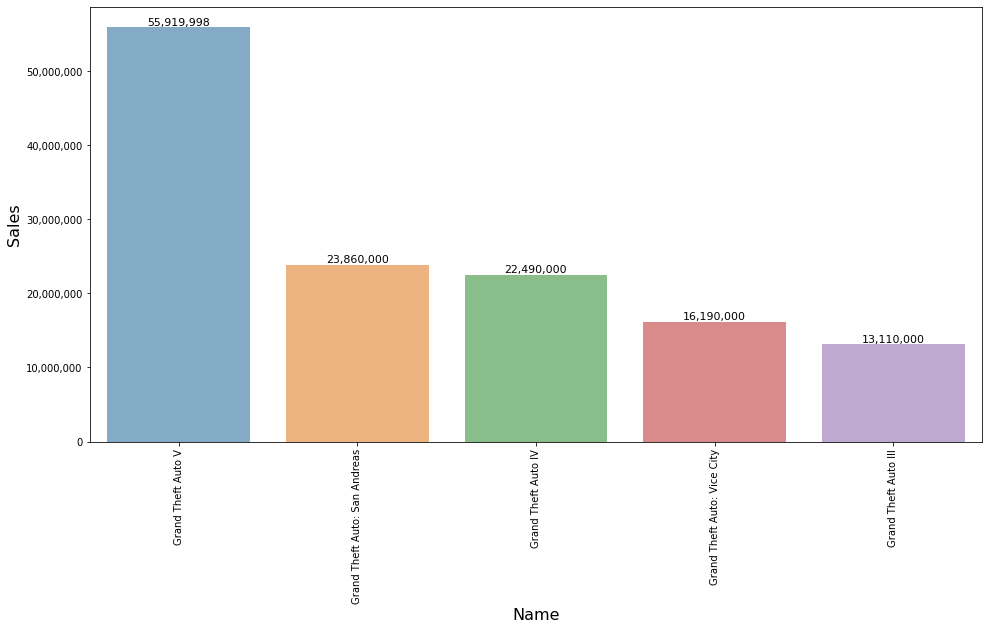

In [84]:
# 테이크투 회사의 TOP5 판매량 게임
plt.figure(figsize=(16,8))
sns.barplot(x=taketwo_top5['Name'], y=taketwo_top5['Sum_Sales'], ci=None, alpha=0.6)
plt.xlabel('Name', fontsize=16)
plt.ylabel('Sales', fontsize=16)
plt.xticks(rotation=90)
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
cnt=0
for i in taketwo_top5['Sum_Sales']:
    plt.text(x=cnt, y=i+300000, s=str('{:,}'.format(i)),
            color='black', size=11, ha='center')
    cnt+=1
plt.show()

In [85]:
# TOP5 모두 GTA 시리즈가 차지 했다. >> GTA를 모티브

In [86]:
# 추가 분석 - 플스 중에서 어떤 종류가 현재 인기 있을까?

In [87]:
# 플스 필터링
dfy_ps = dfy[dfy['Platform_4']=='PlayStation']
# 연도와 구체적인 플랫폼 별로 게임 수 카운트
dfy_ps = dfy_ps.groupby(['Year','Platform']).count().reset_index().iloc[:,:3]
dfy_ps.columns = ['Year','Platform','Count']

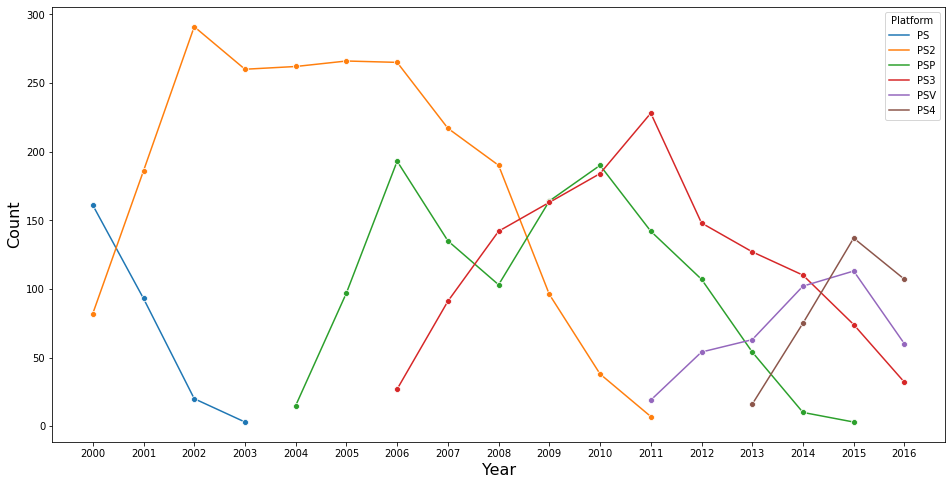

In [88]:
# 플스 동향
plt.figure(figsize=(16,8))
sns.lineplot(x='Year', y='Count', hue='Platform', data=dfy_ps, marker='o')
plt.xlabel('Year', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xticks(np.arange(2000,2017,1))
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
plt.show()

In [89]:
# 가장 최근에 추가된 것은 PS4(2013년 추가)이며, 가장 최근을 기준(15,16년)으로 가장 많은 게임 수를 보이고 있다. > PS4 선택

In [90]:
# 추가 분석 - 액션 게임 지역별 비중

In [91]:
# 장르별로 판매량 구하기
dfy_action_pie = dfy.groupby('Genre').sum().reset_index().iloc[[0],[0,2,3,4,5]]
dfy_action_pie = dfy_action_pie.set_index('Genre')

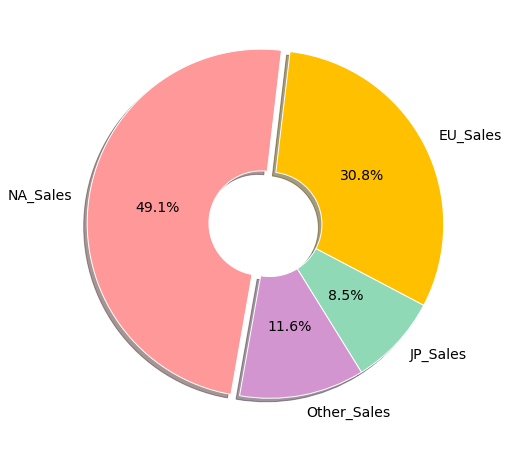

In [92]:
plt.figure(figsize=(8,8))
explode = [0.05,0,0,0]
colors = ['#ff9999', '#ffc000', '#8fd9b6', '#d395d0']
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 1}
# 액션의 지역별 판매량 추출해서 값으로 넣기
plt.pie(dfy_action_pie.T['Action'].tolist(), labels=dfy_action_pie.columns,
        autopct='%.1f%%', startangle=260, counterclock=False, explode=explode,
        shadow=True, colors=colors, wedgeprops=wedgeprops, textprops={'fontsize': 14})
plt.show()

In [93]:
# 미국 시장이 가장 크고 그 다음은 유럽이다. >> 1순위 미국, 2순위 유럽으로 지역 선정을 한다.

In [94]:
# 추가 분석 - 플레이스테이션 지역별 비중

In [95]:
# 플랫폼4별로 판매량 구하기
dfy_plf4_pie = dfy.groupby('Platform_4').sum().iloc[[2],1:5]

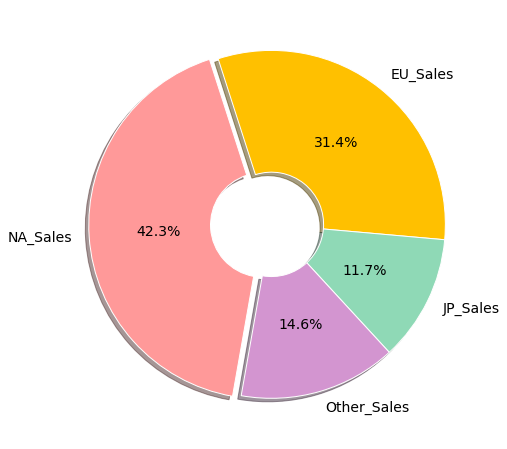

In [96]:
plt.figure(figsize=(8,8))
explode = [0.05,0,0,0]
colors = ['#ff9999', '#ffc000', '#8fd9b6', '#d395d0']
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 1}
# 플레이스테이션의 지역별 판매량 추출해서 넣기
plt.pie(dfy_plf4_pie.T['PlayStation'].tolist(), labels=dfy_plf4_pie.columns,
        autopct='%.1f%%', startangle=260, counterclock=False, explode=explode,
        shadow=True, colors=colors, wedgeprops=wedgeprops, textprops={'fontsize': 14})
plt.show()

In [97]:
# 미국 시장이 가장 크고 그 다음은 유럽이다. >> 1순위 미국, 2순위 유럽으로 지역 선정을 한다.